In [1]:
#----------- IGNORE THIS CODE BELOW ------------------#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
COLORS = ['#242482', '#F00D2C', '#0071BE', '#4E8F00', '#553C67', '#DA5319', '#333333', '#FF0000']
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 14
plt.rc('axes', prop_cycle=cycler(color=COLORS))
#-----------------------------------------------------#

In this notebook, we look at classification algorithms. Recall from lecture, that in **supervised learning**,  data consists of **inputs** and **outputs** pairs $(\boldsymbol x, y)$, where $\boldsymbol x \in \mathbb R^d$ is a $d$-dimensional descriptor vector and $y$ is a quantity. The goal of **supervised learning** is to learn the mapping

$$f(\boldsymbol x) = y$$

that predicts an output for any input. This learning is done with $m$ training data examples or points $\left\{ (\boldsymbol x_i, y_i) \right\}_{i=1}^m$, where $\boldsymbol x_i$ is the descriptor vector for the $i$-th example and $y_i$ is the label for the $i$-th example.

In the **classification**, the outputs are labels for classes. That is, the $y_i$ are merely an identification stating that the corresponding input vector $\boldsymbol x$ "belongs" to some time of qualitative class. As such, while we may typically assign numbers for such labels (such as "1" for the first class, "2" for the second class", etc.) there is generally no sense of order or magnitude -- i.e. class label "1" isn't *a priori* considered closer to class "2" than class "10". These numbers are just indices or labels for qualitative classes. In other words, the $y_i$ represent **categorical data**. To further emphasize this categorical nature
of the outputs, we'll write $c_i$ instead of $y_i$, where it is understood that the $c_i$ are labels or indices.

This has implications regarding the types of algorithms or metrics we use to train and evaluate models. In particular, the sum-of-squared error metric we have used for many of the regression algorithms is no-longer applicable here, since the squared-error loss function $(f_\text{model}(\boldsymbol x_i) - c_i)^2$ between a model prediction $f_\text{model}(\boldsymbol x_i)$ and the corresponding output data value $c_i$ doesn't make any sense when dealing with categorical data -- you can't subtract class labels in any meaningful way.

Therefore, in classification, we need to think about other loss functions and metrics for assessing how well a model predicts categorical data. We'll mostly focus on two types of models - ones that attempt to build-up and extend parametric regression models (and in particular, linear models) and ones that approach classification from more algorithmic / non-parametric perspective.

# Linear models for classification
---

Classification methods such as Logistic Regression and SVM that we discussed in class build on techniques we learned in regression, namely the linear model. Namely, we consider a linear model $ \boldsymbol \varphi(\boldsymbol x) \cdot \boldsymbol \theta $ where 

$$\boldsymbol \varphi(\boldsymbol x) = (\varphi_1(\boldsymbol x), \varphi_2(\boldsymbol x), ..., \varphi_n(\boldsymbol x))$$

is the vector of basis-function values for $n$ basis functions $\varphi_i,$ for $i = 1, ..., n$, and 

$$\boldsymbol \theta = (\theta_1, \theta_2, ..., \theta_n)^T,$$

is the vector of coefficient values (to be solved for during training). This takes on continuous values, and thus is not suitable for classification. To convert the continuous value of the linear value to a binary class label, we simply consider the sign of the value:

$$ c = \text{sgn}(\boldsymbol \varphi(\boldsymbol x) \cdot \boldsymbol \theta),$$

where $\text{sgn}$ is the sign function. 



In [2]:
data = np.loadtxt('data/classification_data.txt')
print(data.shape)

(187, 3)


We see that this data has 187 data points, and each data point has 3 dimensions - 2 inputs and 1 output class. We'll print out the first few rows:

In [3]:
print(data[:10,:])

[[0.36805924 0.99749752 1.        ]
 [0.83136981 0.59144347 1.        ]
 [0.12121577 0.63843711 1.        ]
 [0.61291487 0.55803293 1.        ]
 [0.55080919 0.19565654 1.        ]
 [0.04372468 0.69535014 0.        ]
 [0.71536265 0.58536356 1.        ]
 [0.0380063  0.42635862 0.        ]
 [0.89887218 0.67318259 1.        ]
 [0.34766677 0.99728915 1.        ]]


Here we see that the first two columns serve as the input and the last column is the class label, which takes on a binary 0/1 labeling.

We'll extract the input columns and the class columns and perform some normalization

In [4]:
# Normalized input data (Z-normalization)
x = data[:, 0:2]
x = (x - np.min(x, axis = 0))/ ( np.max(x, axis = 0) - np.min(x, axis = 0) )

# The class data
c = data[:, 2]

For plotting purposes -- specifically to set the colors of each of the classes to red and blue, we'll create this list of color strings. Each entry is just a hexadecimal specification of a color for a corresponding data point.

In [5]:
c_color = []
for i in range(len(c)):
    c_color.append(COLORS[int(c[i])])

With this, we can plot the input data points in the plane (since input is two-dimensional), and color each point according to its class.

Text(0, 0.5, 'x2')

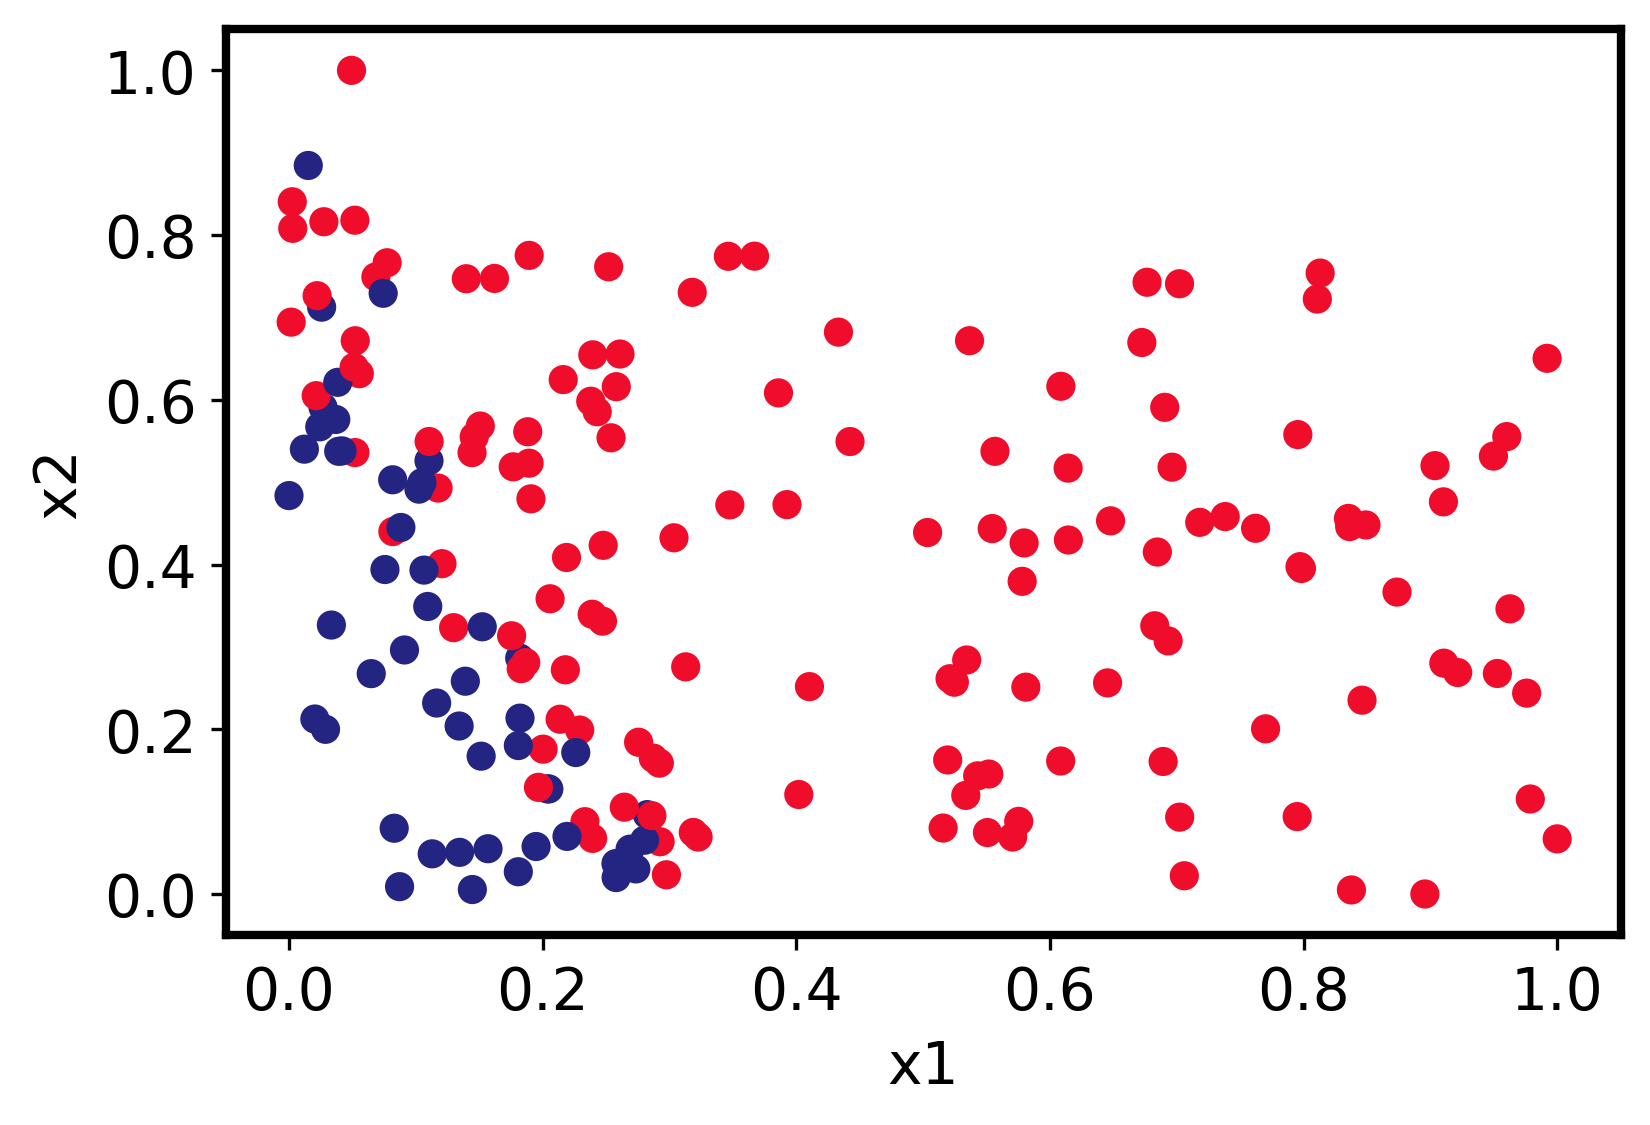

In [6]:
plt.scatter(x[:,0], x[:,1], c=c_color)
plt.xlabel('x1')
plt.ylabel('x2')

Again, the goal of classification is to determine the rule that maps inputs to class. We as humans can look at the above two-dimensional scatter plot and discern such a rule based on the values of $x_1$ and $x_2$. There appears to be a line 
$$x_2 = \theta_1 x_1 + \theta_2$$ 
or maybe some sort of exponential decay, like
$$x_2 = \theta_0 + \theta_1\exp(-\theta_2x_2)$$
that separates the plane into two a "blue" region and "red" region. Our goal with studying classification algorithms is to figure out how to get computers to do this, in high dimensions.

For now, let's assume that we'll use a line partition the plane, and write the equation of the line using a slightly different notation:

$$ 1\cdot\theta_0 + x_1\cdot\theta_1 +x_2\cdot\theta_2 = 0 $$

or in vector form:

$$ \boldsymbol \varphi(\boldsymbol x)\cdot \boldsymbol \theta = 0,$$

where $\varphi(\boldsymbol x) = (1, x_1, x_2)$ and $\boldsymbol \theta = (\theta_0, \theta_1, \theta_2)^T$. Again, this defines a line -- the set of points $\boldsymbol x = (x_1, x_2)$ that satisfy this is a line. Points where $\boldsymbol \varphi(\boldsymbol x) \cdot \boldsymbol \theta > 0$ lie on one side of this line, and points where the sign of $\boldsymbol \varphi(\boldsymbol x) \cdot \boldsymbol \theta < 0$ will lie on the opposite side. In this way the sign of the output of the linear model determines which half-plane (below or above the defining line) we assign to one class or the other. This is the entire premise of classification algorithms such as Logistic regression (and SVM, as we'll see later).

Of course, the actual line we consider depends on the values of the coefficients, so let's play around with some sample values. To do this, we'll take the linear model defined by a given coefficient vector, and calculate the linear model values for several points in the plane. Below, we define the list of inputs that we'll evaluate our models on.

In [7]:
# Form all combinations of points in the unit square
x1_plot = np.linspace(0, 1, 100)
x2_plot = np.linspace(0, 1, 100)

# The next two lines forms all combinations of points from x1_plot and x2_plot
X1, X2 = np.meshgrid(x1_plot, x2_plot)
x_plot = np.array([X1.ravel(), X2.ravel()]).transpose()

print(x_plot.shape)

(10000, 2)


In the above code, we looked at all pairs of points $\boldsymbol x = (x_1, x_2)$ for $x_1$ and $x_2$ each taking 100 equally spaced values between 0 and 1. Once we define the points we wish to evaluate our linear model on, we'll form the Design matrix $\Phi$ for these points, then compute the product $\boldsymbol y = \Phi \boldsymbol \theta$ to calculate the linear model at every point, for some value of $\boldsymbol \theta = [0.2, -1, 0.2]$ picked arbitrarily. 

First, we'll define a Python function to form the design matrix (similar to our use of `np.vander` for the univariate monomial basis). We'll use this code often in this notebook, so it's good to put the code in its own function.

In [8]:
def form_design_matrix(x):
    phi_0 = np.ones(len(x))
    phi_1 = x[:, 0]
    phi_2 = x[:, 1]
    return np.array([phi_0, phi_1, phi_2]).T

Once defined, we can use it to evaluate the basis functions at any set of points, and thus calculate the design matrix. With the design matrix, we can evaluate the linear model for any choice of coefficients.

In [9]:
# Evaluate basis functions at every point in x_plot, then evaluate linear model for the given theta value
Phi = form_design_matrix(x_plot)
theta = [0.2, -1, -0.2]
y_plot = Phi @ theta

We can use these evaluated values to summarize linear function through its contours. To do that, we'll use the `matplolib.pyplot.contour` function. Please consult the documentation for an explanation of the various arguments we use below. In addition to the coutours of the linear function, we also plot the data for reference.

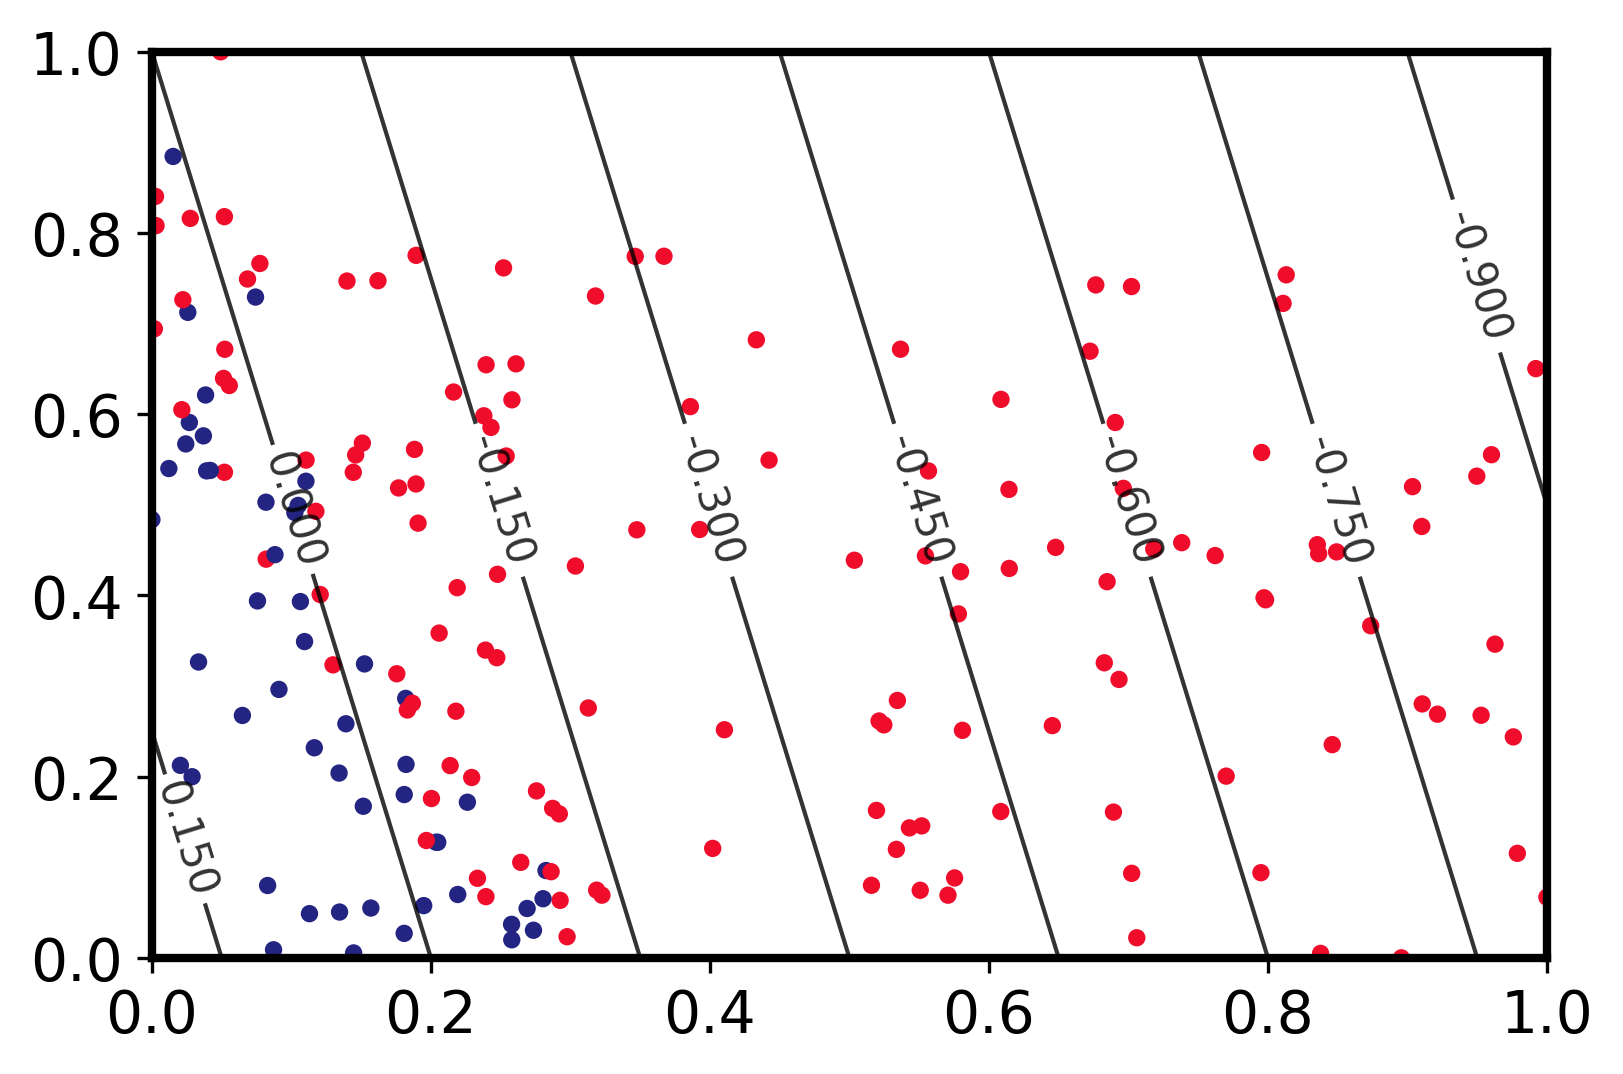

In [10]:
Y = np.reshape(y_plot, X1.shape)
cs = plt.contour(X1, X2, Y, levels = 10, 
                 linewidths=1, linestyles='solid', colors=['k'], alpha = 0.8)
plt.gca().clabel(cs, inline=1, fontsize=10)
plt.scatter(x[:,0], x[:,1], c=c_color, s = 10)

We see that the contour where $y = \boldsymbol \varphi(\boldsymbol x)\cdot \boldsymbol \theta$ equals 0 actually serves as a decent boundary between the blue class and red class. We also note that the linear value takes on negative values to the left/below this boundary, and positive values to the right/above this boundary.

That is, the sign of the linear model determines which side of the boundary line is assigned to the blue or negative class if we were to use this linear model as stated above. To make this explicit, we'll color every region of the plane according to the sign of the linear model. To do that, we use the `matplotlib.pyplot.pcolormesh` function. We also plot the original data for reference.

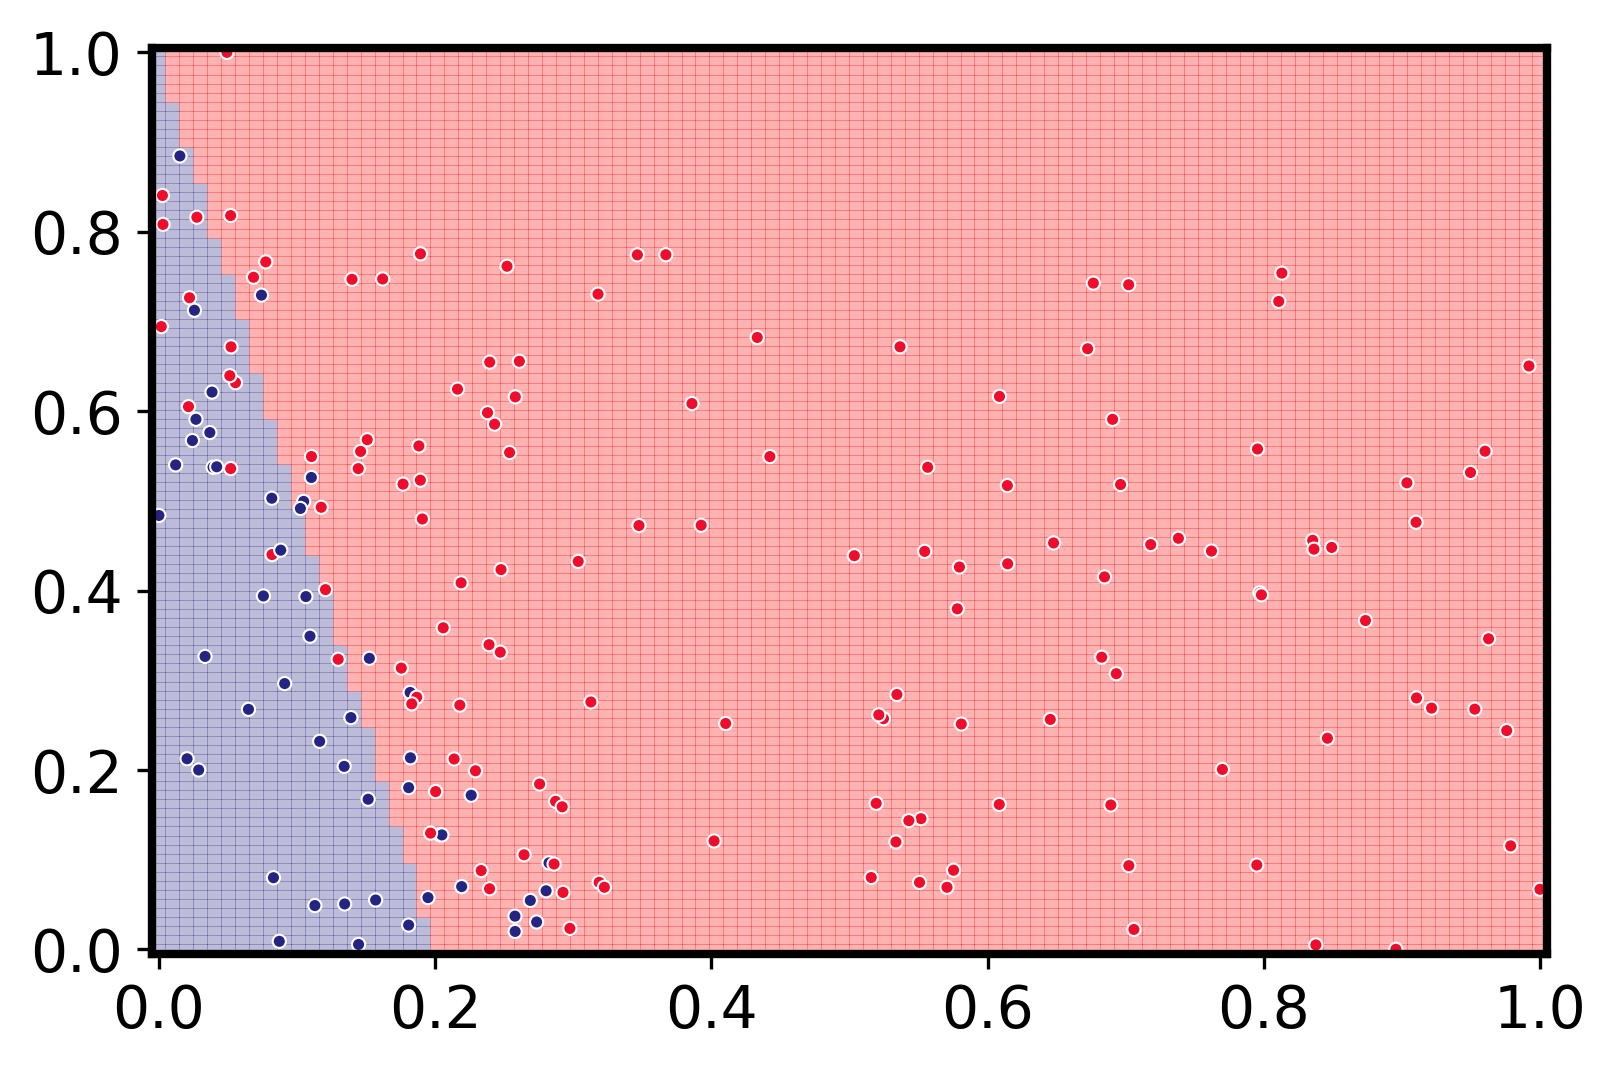

In [11]:
from matplotlib.colors import ListedColormap
plt.pcolormesh(X1, X2, Y < 0, cmap=ListedColormap(COLORS), shading='auto', alpha=0.3)
plt.scatter(x[:,0], x[:,1], c=c_color,
            s = 10, edgecolors='w', linewidths=0.5)

This plot is a visualization of the classifier. Points in the blue region would be deemed one class by this classifier, and points in the red region would be assigned to the other class. We see that, the many points -- especially the red points -- are classified correctly. However we note 1) Many points are misclassified and 2) It's actually relatively easy to correctly classify most of the red points because there are so many of them. 

Of course, the choice of the $\boldsymbol \theta$ was made arbitrarily and not at all optimized against the data. Below we'll explore two methods to better select $\boldsymbol \theta$.

# Logistic regression
---

With the Logistic Regression model, we are simply using the maximum likelihood estimate $\hat{\boldsymbol \theta}_\text{MLE}$ to select coefficients. However, to do this, we need to calculate likelihoods: the probability of observing the given data for a particular choice of $\boldsymbol \theta$. To calculate likelihoods, therefore, we need a probabilistic model for the data. Unlike in regression, we don't assume that output data and noise is drawn from Gaussian distribution, since output is categorical. Instead, we'll assume that the (binary) output data $c_i$ are samples of iid Bernoulli random variables $C_i$:

$$ C_i \sim \text{Bern}(p_i).\quad\quad(1)$$

where the probability $p_i$ is modeled using the logistic function:

$$ p_i = \frac{\exp^{\boldsymbol \varphi(\boldsymbol x_i) \cdot \boldsymbol \theta}}{1 + \exp^{\boldsymbol \varphi(\boldsymbol x_i) \cdot \boldsymbol \theta}}. \quad\quad(2)$$

This logistic model for the probabilities of the Bernoulli RVs used to model the data is where Logistic Regression derives its name, or at least the "Logistic" part.

This gives us a means of calculating likelihood. The likelihood of a classification model based on the linear model above for a specific $\boldsymbol \theta$, given some a data point $(\boldsymbol x, c)$ is (under (1) and (2) above) is simply the probability the Bernoulli RV $C$  in (1) takes on the value $c$, where the probability of the success of the Bernoulli trial is given by (2). That is if "$c$" is the positive/success/red class, then this likelihood is just as given by the probability in (2). Otherwise the likelihood is the compliment of this probability:

$$\mathcal L\left[ \boldsymbol \theta | (\boldsymbol x, c) \right] = \mathbb P_{C \sim \text{Bern}(p(\boldsymbol \theta))}\left[ C = c \right],$$

where $p = p(\boldsymbol \theta)$ is defined by (2). For more than 1 data point, we make the usual independence assumption, and form the product of the individual likelihood values, over all the data points. Then, for the Logistic Regression model, we select the $\boldsymbol \theta$ that makes this likelihood.

---- 
#### Exercise

Write a function `calc_likelihood(theta, data)` that calculates the likelihood for the linear classifier defined by `theta`. Use this function to calculate the likelihood value for coefficient values $\boldsymbol \theta = [0.2, -1, \theta_3]$, for different values of $\theta_3$. Plot the likelihood (or perhaps the natural logarithm of the likelihood versus $\theta_3$. Identify which $\theta_3$ is best, and plot the resulting classification of the plane, like we did above.

---

This is what goes on "underneath-the-hood" in implementations of logistic regression algorithms, such as the one in `sklearn`, which can be found in `sklearn.linear_model.LogisticRegression`. As usual, we'll use the 3-step procedure we've used in the past for other `sklearn` models, namely we'll:

1. Instantiate a `LogisticRegression` object, providing any hyper-parameters needed to do this instantiation.
2. Train the model using the object's `fit` function.
3. Make subsequent predictions using the train model using the objects `predict` function.

First, we instantiate the object.

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept = False)

We specify only one hyper-parameter here (other than our choice of basis functions), setting `fit_intercept` to `False`. This is because we'll explicitly include a column of 1s in our design matrix so we know that one of the coefficients (namely $\theta_0$) will serve as the intercept value. 

Once instantiated, we pass in the training data set to train the model. Per our standard rule-of-thumb, we'll reserve 20% of the data for testing, and 20% of the remaining for model validation / hyperparameter calibration, the remaining data becomes training data.

In [13]:
num_points = len(data)

# Calculate the number of points in the training data set
num_train = int(num_points*0.8*0.8)

# Calculate the number of points in the validation data set
num_valid = int(num_points*0.8*0.2)

# Extract the training, validation and testing sets (Inputs, outputs and color strings)
x_train = x[:num_train,:]
c_train = c[:num_train]
c_color_train = c_color[:num_train]
    
x_valid = x[num_train:num_train+num_valid,:]
c_valid = c[num_train:num_train+num_valid]
c_color_valid = c_color[num_train:num_train+num_valid]

x_test = x[num_train+num_valid:,:]
c_test = c[num_train+num_valid:]
c_color_test = c_color[num_train+num_valid:]

Now we form the design matrix for the training data. Recall, we'll use 3 basis functions:

$$\varphi_0(\boldsymbol x) = 1,$$

$$\varphi_1(\boldsymbol x) = x_1,$$

$$\varphi_2(\boldsymbol x) = x_2.$$



In [14]:
Phi_train = form_design_matrix(x_train)
print(Phi_train.shape)

(119, 3)


Once we form the design matrix for the training data, we call the `fit` function for the Logistic Regression model

In [15]:
model.fit(Phi_train, c_train)

LogisticRegression(fit_intercept=False)

Once we fit the model, we can ask it to predict the class for any inputs. We once again make predictions for the set of points we formed earlier, defined by the list of points in `x_plot`. To make the predictions, we must form the design matrix for these points (using the same basis functions), and then call `model.predict`.

In [16]:
Phi_plot = form_design_matrix(x_plot)
c_plot = model.predict(Phi_plot)

We can see what the `predict` model returns by printing out the first few predictions.

In [17]:
print(c_plot[:10])

[0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]


We see that it returns 0/1 encoding for the two classes.

To visualize these predictions, we once again color the entire plane by the predictions made at the points in `x_plot`. This means we have to reshape the predictions so that we can use `pcolormesh` correctly. As before, we'll also plot the data, but this time, we'll distinguish the points that were trained against by using a triangle to indicate such points.

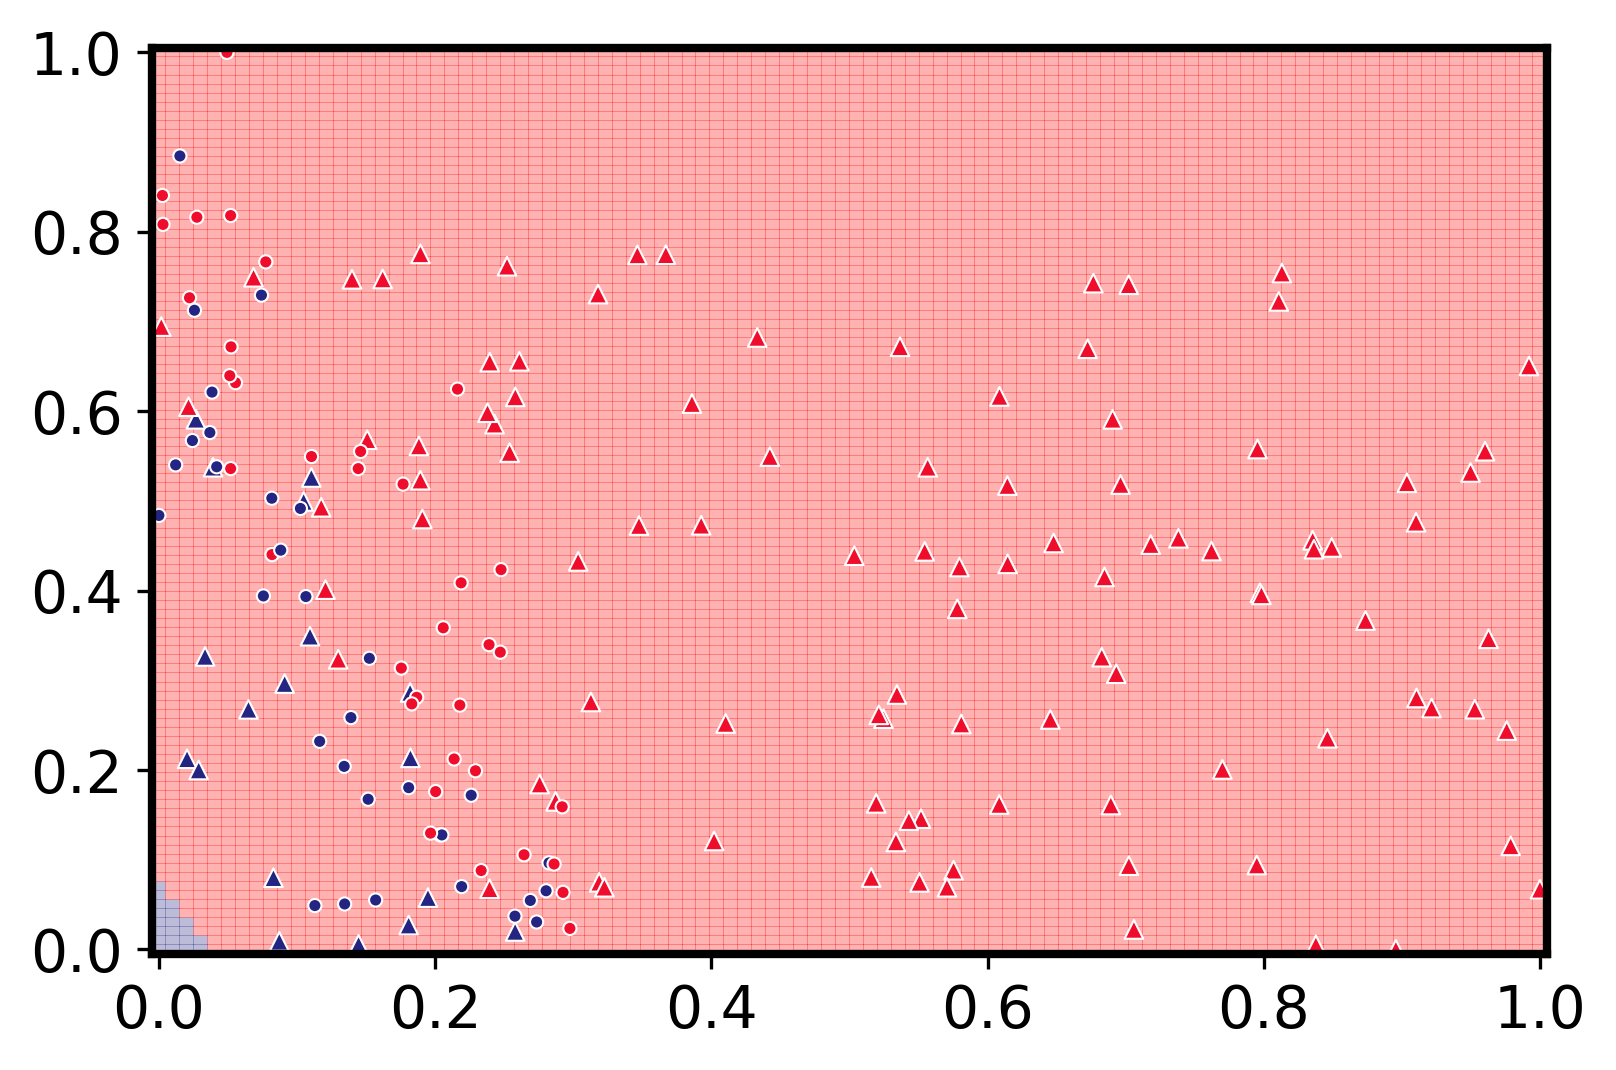

In [18]:
def plot_classification(c_plot):
    C_plot = c_plot.reshape(X1.shape)
    plt.pcolormesh(X1, X2, C_plot, cmap=ListedColormap(COLORS), shading='auto', alpha=0.3)

    # Plot the training data with triangles
    plt.scatter(x_train[:, 0], x_train[:,1], c=c_color_train, marker = '^',
                s = 20, edgecolors='w', linewidths=0.5)

    # Plot the validation and testing data with circles
    plt.scatter(x_valid[:, 0], x_valid[:,1], c=c_color_valid,
                s = 10, edgecolors='w', linewidths=0.5)

    plt.scatter(x_test[:, 0], x_test[:,1], c=c_color_test,
                s = 10, edgecolors='w', linewidths=0.5)
    
plot_classification(c_plot)

This doesn't look right at all. What went wrong? Apart from the choice of basis functions, we ostensibly had no other "moving-parts" to this model that we could have used incorrectly. That is, there doesn't seem to be an opportunity to make a mistake in the application of this model, and our choice of linear basis functions seems to be at least somewhat appropriate -- the separating boundary looks like it can be approximated by a line. So why are we getting such poor performance from the `LogisticRegression` model from `sklearn`?



---

#### Exercise

One issue we *might* have come across is bad or poorly represented data in the training data set. Explore the training data to see if there is anything that could potentially explain the above plot, or contribute to the poor performance of this model.

---

Checking the documentation for this model, we note a particular warning:

---

**Note:** Regularization is applied by default, which is common in machine learning but not in statistics. Another advantage of regularization is that it improves numerical stability. No regularization amounts to setting `C` to a very high value.

---

That is, rather than maximizing likelihood (which amounts to minimizing an analogous cost function), the implementation of logistic regression in `sklearn` automatically adds a regularization penalty term, such as
the $L_2$ penalty term (as in Ridge regression) or the $L_1$ term in LASSO. This means that lurking in the background is a tunable hyper-parameter -- the regularization hyper-parameter -- which must be optimized during validation for the model to work well, or be set to a nominally large value to remove regularization. The default value of `C=1` for this hyper-parameter simply was not good for our data. (Why it's not good could also have something to do with issues you identified in the above exercise).

For now, until we talk about metrics for classification performance -- which we'll need to properly perform a model validation / hyper-parameter optimization study --  we'll set it to large number value to simply maximize likelihood. To do this, we set `C` to some arbitrarily large value, like $10^9$.




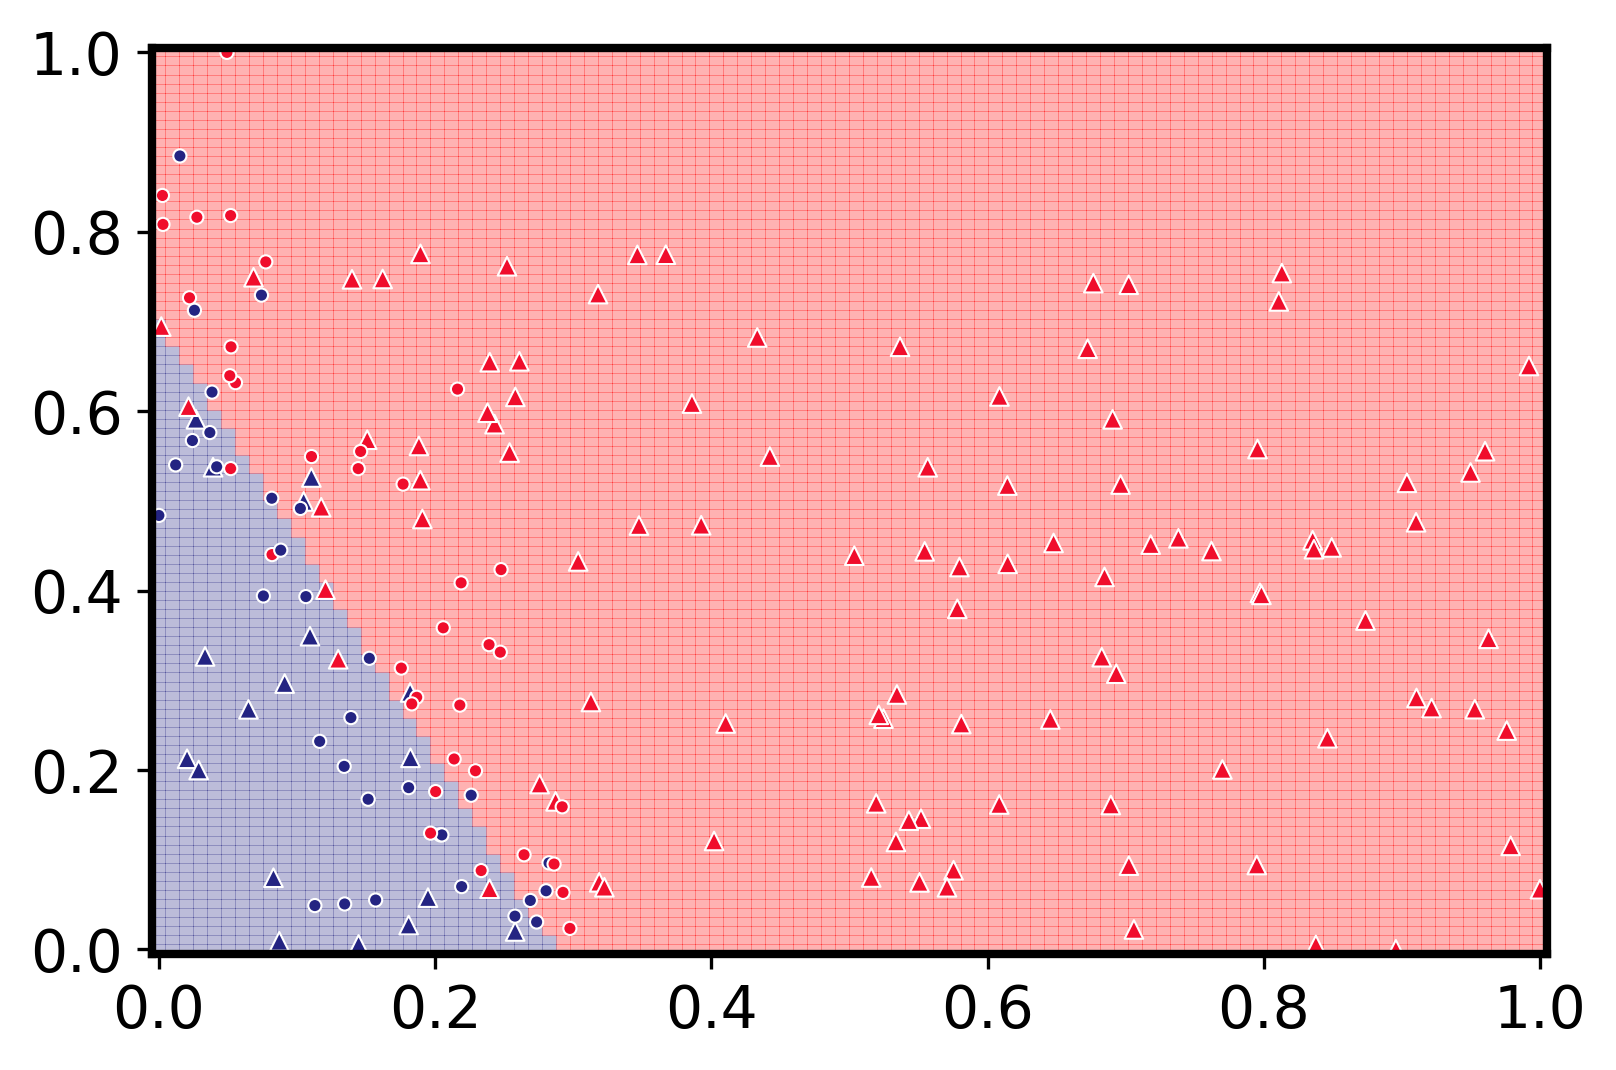

In [19]:
model = LogisticRegression(fit_intercept = False, C = 1e9)
model.fit(Phi_train, c_train)
c_plot = model.predict(Phi_plot)
plot_classification(c_plot)

This is effectively the classification (i.e. the choice of coefficients $\boldsymbol \theta$) that maximizes likelihood of observing the training data -- without worrying about issues such as regularization). We note that it does a decent job, but there are still a few (inevitable) mis-categorizations.

Once trained, we can get the coefficients of the linear model lurking in the background, using the `coef_[0]` field

In [20]:
print(model.coef_[0])

[-10.36865708  36.09966355  14.78884684]


This means the MLE for the coefficients are roughly $\theta_0 = -10$, $\theta_1 = 36$, and $\theta_2 = 15$.

Transforming
$$\theta_0 + \theta_1 x_1 + \theta_2 x_2 = 0$$
to point-slope form, we see that
$$
\begin{align}
x_2 &= -\frac{\theta_1}{\theta_2} x_1 - \frac{\theta_0}{\theta_2} \\
    &= -2.4x_1  + 0.66 \\
\end{align}
$$

We can explicitly plot this line in the $x_1, x_2$ plane.

(0.0, 1.0)

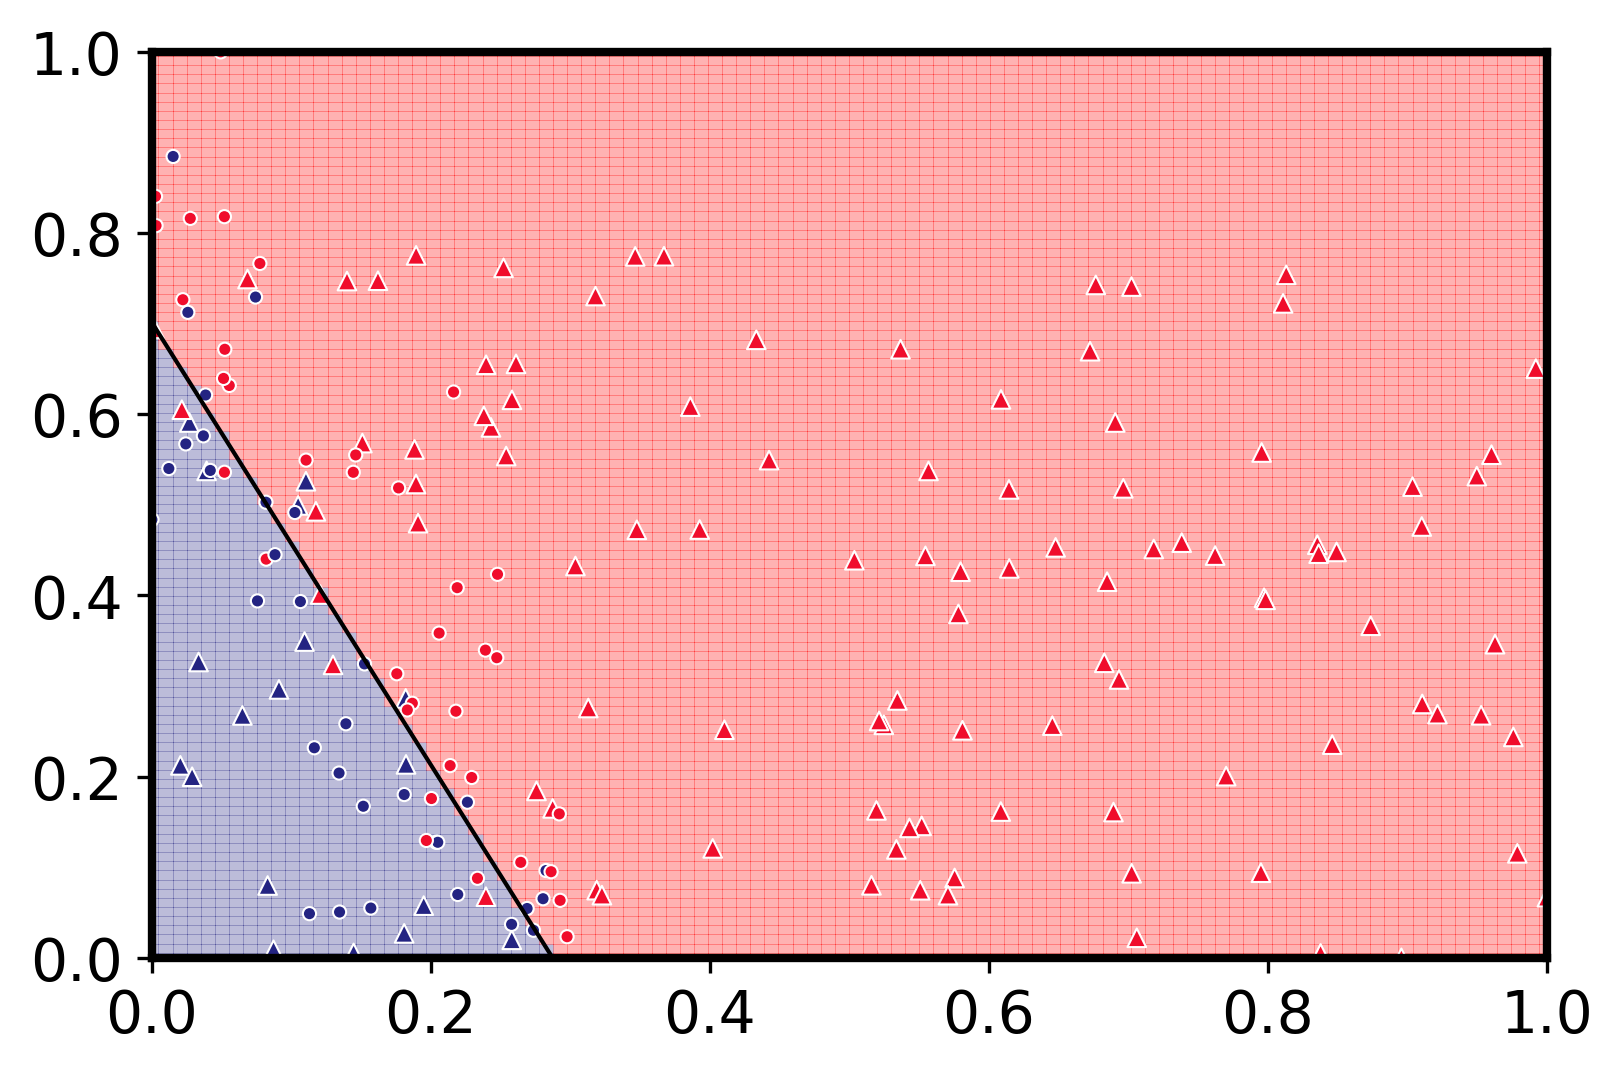

In [21]:
theta = model.coef_[0]
level_set_plot = -theta[1]/theta[2]*x1_plot - theta[0]/theta[2]
plot_classification(c_plot)
plt.plot(x1_plot, level_set_plot, c = 'k', linewidth=1)
plt.xlim([0,1])
plt.ylim([0,1])

We can also use this to calculate the value of the trained linear model at arbritrary points. For example, for a point in the blue region, like $\boldsymbol x = (0.1, 0.2)$:

In [22]:
val = theta[0] + theta[1]*0.1 + theta[2]*0.2
print(val)

-3.800921353846026


We see therefore that everything below this line has a negative linear model value, and so we'll refer to the blue class as the "negative" class throughout this note. We'll correspondingly call the red class the "positive" class.

# Metrics for Classification Performance

Looking at the above example, we can be more specific regarding the classification performance. For example, we can count how many "blue" points were miscategorized vs. "red" points. We can further qualify such measures based on the overall population size of the blue vs. red points.

First, lets count the correct cagegorizations

In [23]:
model = LogisticRegression(fit_intercept = False, C = 1e9)
Phi_train = form_design_matrix(x_train)
model.fit(Phi_train, c_train)

# Make predictions on trainind and validation data
c_model_train = model.predict(Phi_train)

Phi_valid = form_design_matrix(x_valid)
c_model_valid = model.predict(Phi_valid)

# Count miscategorizations
num_correct_train = np.sum(c_train == c_model_train)
num_correct_valid = np.sum(c_valid == c_model_valid)

print("%d training points were correctly categorized" % num_correct_train)
print("%d validation points were correctly categorized" % num_correct_valid)

111 training points were correctly categorized
22 validation points were correctly categorized


Because the validation and training data sets were of different sizes, we should probably calculate the percentage of correct  points relative to the data set size. The resulting metric is called the model **accuracy**. 

In [24]:
acc_train = num_correct_train / num_train

acc_valid = num_correct_valid / num_valid

print("Training accuracy = %f, validation accuracy = %f" % (acc_train, acc_valid))

Training accuracy = 0.932773, validation accuracy = 0.758621


Thus we see that 93% of the training data was correctly categorized, while 76% of the validation was correct. This is analogous to getting 93% on a practice test and 76% on the real exam.

While this is relatively straight-forward to calculate, `sklearn` has an this metric implemented inside its `sklearn.metrics.accuracy_score` function. To use this, you provide the function both the true classes and the model predictions. The function returns the accuracy as we had calculated it above.

In [25]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(c_train, c_model_train)
print("Training accuracy = %f"%acc_train)

Training accuracy = 0.932773


We can drill down on this accuracy, as it doesn't really capture the full story. For one, we can calculate the the number of false positives: the number of points predicted to be of the "positive" (red) class when the ground truth was actually negative. We can also analogously calculate the number of false negatives, the points incorrectly labeled as negative.

In [26]:
num_fp_train = np.sum((c_train == 0) & (c_model_train == 1))
num_fn_train =  np.sum((c_train == 1) & (c_model_train == 0))

print("%d false positives, %d false negatives in training data"%(num_fp_train, num_fn_train))

3 false positives, 5 false negatives in training data


While these metrics further break down the mistakes the models make, we can also calculate similar metrics based on what the model gets right, namely the number of true positives and negatives.

In [27]:
num_tp_train = np.sum((c_train == 1) & (c_model_train == 1))
num_tn_train =  np.sum((c_train == 0) & (c_model_train == 0))

print("%d true positives, %d true negatives in training data"%(num_tp_train, num_tn_train))

96 true positives, 15 true negatives in training data


---

#### Exercise

Make 4 plots of the data and classifier like we did above, but for each of the four plots, only plot scattered data points respectively corresponding to the false positives, false negatives, true positives and true negatives.

---

Together, these four numbers: True positives (TP), True negatives (TN), False positives (FP) and False Negatives (FN) constitute what's called the **Confusion Matrix**, and many other metrics are based off of them. We can calculate all of these numbers with one call to the appropriate `sklearn` metrics function, `sklearn.metrics.confusion_matrix`

In [28]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(c_train, c_model_train)
print(cm_train)

[[15  3]
 [ 5 96]]


We see that `cm[0,0]` is the number of true negatives while `cm[0,1]` is the number of false positives -- that is, the first row corresponds to data that is actually negative, regardless of what the model predicts it to be. Analogously, `cm[1, 0]` is the number of false negatives while `cm[1,1]` is the number of true positives, so that the second row corresponds to data that is actually positive. With respect to columns: the first column corresponds to data that is predicted to be negative, regardless of whether it actually is negative or not, while the second column partitions the data that is predicted to be positive.

We can calculate the confusion matrix for the validation data as well

In [29]:
cm_valid = confusion_matrix(c_valid, c_model_valid)
print(cm_valid)

[[ 6  3]
 [ 4 16]]


These four values help define further metrics that form a multifaceted notion of classification performance. These metrics help highlight specific deficiencies of a classification model. We'll cover just two of them here: precision and recall.

### Recall

**Recall** is defined as the number of true positives (TP) divided by number of points actually positive (TP + FN):

$$\text{Recall} = \frac{\text{TP}}{\text{TP + FN}}.$$

The recall value of a classifier is between 0 and 1, with larger values signifying better classification. A recall of 1 occurs if a classifier identifies all the positive data correctly. A value of 0  occurs if none of the positive data was identified correctly.

Using the confusion matrix values, we can calculate the recall rate for our example, where the denominator being the sum of the second row.

In [30]:
recall = cm_train[1,1]/np.sum(cm_train[1,:])
print(recall)

0.9504950495049505


We can alternatively use the function `sklearn.metrics.recall_score`

In [31]:
from sklearn.metrics import recall_score

recall = recall_score(c_train, c_model_train)
print(recall)

0.9504950495049505


Note that recall rates only depend on the data that is actually positive and our model's ability to detect such data. Consider what happens if we label ALL data points as positive.

In [32]:
c_bad_model = np.ones(len(c_train))
recall = recall_score(c_train, c_bad_model)
print(recall)

1.0


If we label all points as positive, we get a recall value of 1 -- we've successfully labeled all positive data as such, regardless of what we labeled the truly negative values. We didn't have any false negatives because this bad model never labeled any data as negative. As such, while we'd like a high recall value, recall by itself doesn't convey the entire story.

### Precision

Precision is defined as the number of true positives (TP) divided by the total number of data points predicted to be positives (TP + FP):

$$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}.$$

Precision looks at the data predicted to be positive and considers how many such points are actually positive. Like recall, this precision rate is a number between 0 and 1, with higher precision values being more desirable. A high precision rate implies a model that carefully picks the positive points -- perhaps at the detriment of falsely labeling some data as negative.

Using the confusion matrix, we can calculate precision directly, the denominator being the sum of the second column:

In [33]:
precision = cm_train[1,1]/np.sum(cm_train[:,1])
print(precision)

0.9696969696969697


We can also calculate precision using `sklearn.metrics.precision_score`:

In [34]:
from sklearn.metrics import precision_score

precision = precision_score(c_train, c_model_train)
print(precision)

0.9696969696969697


Like recall, precision only tells one side of the story. Namely a high precision measures the quality of the positive predictions. Calculating the precision for the model that predicts all data as positive highlights this:

In [35]:
precision = precision_score(c_train, c_bad_model)
print(precision)

0.8487394957983193


We see that while the bad model achieves a recall of 1 (better than logistic regression) it achieves a value of 0.85, worse that logistic regression. Of course, this precision for the bad model is additionally made artificially large due to the large number of true values in the data -- that is, the data itself is imbalanced.

A model that is very conservative, assigning a negative label to data points unless it is absolutely sure the point is positive results in a high precision score. In this setting, the data points predicted to be positive will most likely be actually positive, but many other points actually positive may be labeled as negative. 

To illustrate this, we consider another classifier that takes the linear model values obtained by the optimized MLE estimate of the coefficients, but instead of assigning the class based on the sign of these values, assigns a positive class only if the linear model attains a value $y_\text{thresh}$ or larger. A value $y_\text{thresh} = 0$ corresponds to the usual classifier, while larger more positive values correspond to a more conservative classifier. 

Below we calculate the predicted classes for the training data by calculating the linear model values on the training data.

In [36]:
model = LogisticRegression(fit_intercept = False, C = 1e9)
Phi_train = form_design_matrix(x_train)
model.fit(Phi_train, c_train)

theta = model.coef_[0]
y_train = Phi_train @ theta

Now we calculate a threshold based on some percentile -- say 95% -- of the observed values in `y_train`.

In [37]:
# Calculate the threshold based on the data itself, using 95 percentile
y_thresh = np.percentile(y_train, 95)

# Classify each point by their y values
c_conservative_model = [1 if y_train_i > y_thresh else 0 for y_train_i in y_train]

Once we've calculated this conservative model's predictions, we can calculate precision and recall

In [38]:
precision = precision_score(c_train, c_conservative_model)
print(precision)

1.0


In [39]:
recall = recall_score(c_train, c_conservative_model)
print(recall)

0.0594059405940594


We see that this conservative model has a precision of 1.0: 100% of the data it predicts to be true is actually true. However, the model has a recall of 0.06: only 6% of the actual true data was predicted to be true.

Ideally we'd like both of these values to be large, close to 1. As a simple hyper-parameter, let's tune the percentile value we use to obtain the threshold, and consider precision and recall as a function of this parameter. To aid in this, we'll define a function that takes in this percentile value and returns the precision and recall.

In [40]:
def precision_and_recall(percentile, theta, x_data, c_data):
    Phi = form_design_matrix(x_data)
    y = Phi @ theta
    
    y_thresh = np.percentile(y, percentile)
    c_model = [1 if y_i >= y_thresh else 0 for y_i in y]
    
    precision = precision_score(c_data, c_model)
    recall = recall_score(c_data, c_model)
    
    return precision, recall

By the way, the above function shows an example of returning more than one value from a function. This is an example of the Python syntactic sugar called automatic packing/unpacking. In reality, this is just short-hand for returning a tuple containing the precision and recall values as entries. 

Once we define this, we can calculate the precision and recall for versus percentile values. We'll do this for both the training data and validation data.

In [41]:
percentile = np.linspace(0, 100, 20)

# Train the base-model on training data
model = LogisticRegression(fit_intercept = False, C = 1e9)
Phi_train = form_design_matrix(x_train)
model.fit(Phi_train, c_train)
theta = model.coef_[0]

# Pre-allocate the matrices that will hold the precision and recall values
# for each percentile in the percentile array
train_metrics = np.zeros([len(percentile),2])
valid_metrics = np.zeros([len(percentile),2])

for i, p in enumerate(percentile):
    train_metrics[i,:] = precision_and_recall(p, theta, x_train, c_train)
    valid_metrics[i,:] = precision_and_recall(p, theta, x_valid, c_valid)

Once we calculate the metrics, we can plot them. We'll use the `subplot` command which lets us plot two plots side-by-side.

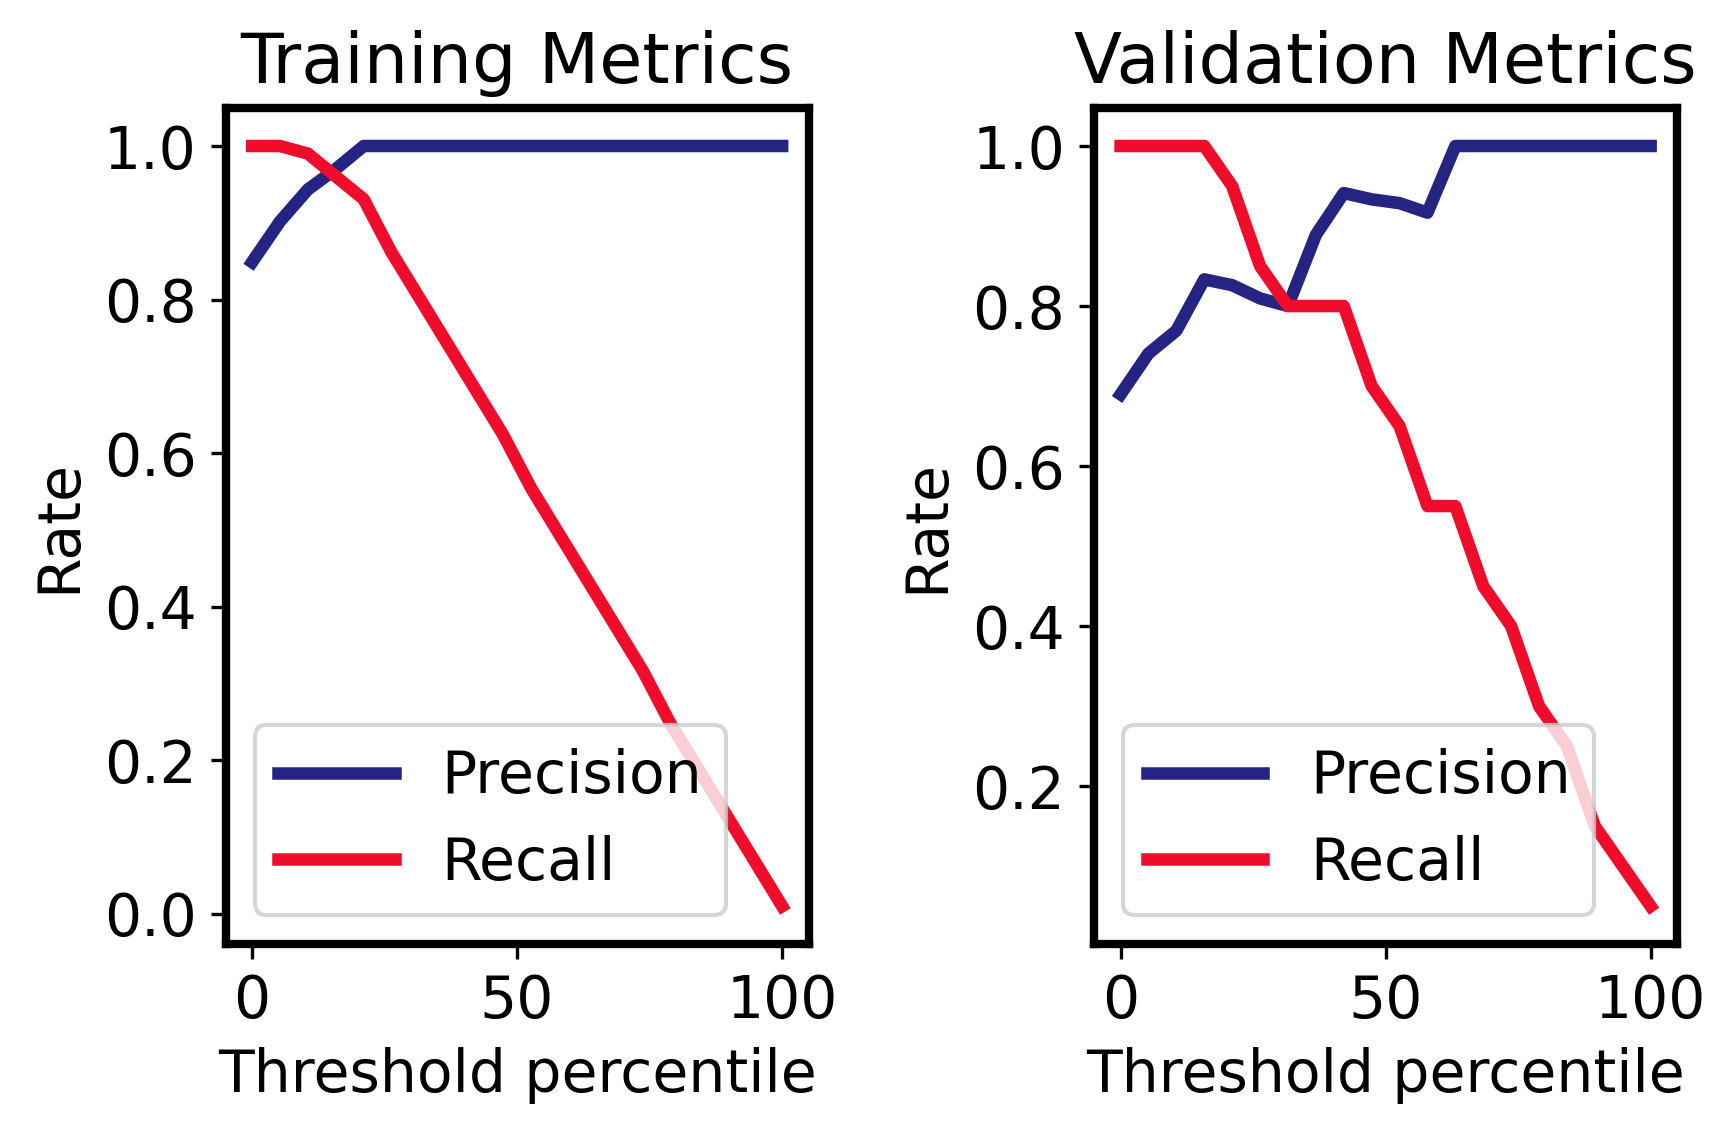

In [42]:
# Plot the training metrics (1st column of a 1x2 grid of plots)
plt.subplot(1, 2, 1)
plt.title('Training Metrics')
plt.plot(percentile, train_metrics)
plt.legend(['Precision', 'Recall'])
plt.xlabel('Threshold percentile')
plt.ylabel('Rate')

# Plot the validation metrics (2nd column of a 1x2 grid of plots)
plt.subplot(1, 2, 2)
plt.title('Validation Metrics')
plt.plot(percentile, valid_metrics)
plt.legend(['Precision', 'Recall'])
plt.xlabel('Threshold percentile')
plt.ylabel('Rate')

# Fixes spacing when using suplot
plt.tight_layout()

We see that increasing the threshold percentile -- that is by making the classifier more conservative when assigning the positive class -- we increase precision but decrease recall. Choosing the "correct" value for the threshold percentile requires some knowledge of how the classifier will be used. At a base level, you should understand whether -- for the specification application -- it is better to be more precise in identifying data or more exhaustive when labeling positive data.

### F-score

The F score is just a way of combining precision and recall under the interpretation that both metrics are indeed rates. Under this interpretation, the correct way of combining precision and recall is using the harmonic average. 

Specifically, the $F_1$ score is defined as unweighted harmonic average of precision and recall:

$$F_1 = \frac{1}{ 0.5 \cdot \text{Precision}^{-1} + 0.5 \cdot\text{Recall}^{-1}}.$$

Here, the "1" in the subscript and "unweighted" above are meant to imply that the contribution of precision and recall are equal. That is $F_1$ is an average of both precision and recall where both are deemed as equally important.

The use of the F-score doesn't eliminate the dilemma posed above in balancing between precision or recall to select optimal hyper-parameters, for example. It is simply one way to address that dilemma, namely treat both metrics as equal.

We can calculate the F1 score using `sklearn.metrics.f1_score`. For example, we can use it along-side precision and recall when calculating metrics to select optimal percentile thresholds in our "conservative" classifier example.

In [43]:
from sklearn.metrics import f1_score

def calculate_metrics(percentile, theta, x_data, c_data):
    Phi = form_design_matrix(x_data)
    y = Phi @ theta
    
    y_thresh = np.percentile(y, percentile)
    c_model = [1 if y_i >= y_thresh else 0 for y_i in y]
    
    precision = precision_score(c_data, c_model)
    recall = recall_score(c_data, c_model)
    f1 = f1_score(c_data, c_model)
    
    return precision, recall, f1

We repeat the above study on metric values versus percentil values

In [44]:
percentile = np.linspace(0, 100, 20)

# Train the base-model on training data
model = LogisticRegression(fit_intercept = False, C = 1e9)
Phi_train = form_design_matrix(x_train)
model.fit(Phi_train, c_train)
theta = model.coef_[0]

# Pre-allocate the matrices that will hold the precision, recall, and
# F1 values for each percentile in the percentile array
train_metrics = np.zeros([len(percentile), 3])
valid_metrics = np.zeros([len(percentile), 3])

for i, p in enumerate(percentile):
    train_metrics[i,:] = calculate_metrics(p, theta, x_train, c_train)
    valid_metrics[i,:] = calculate_metrics(p, theta, x_valid, c_valid)

Once calculated, we can once again plot these metrics

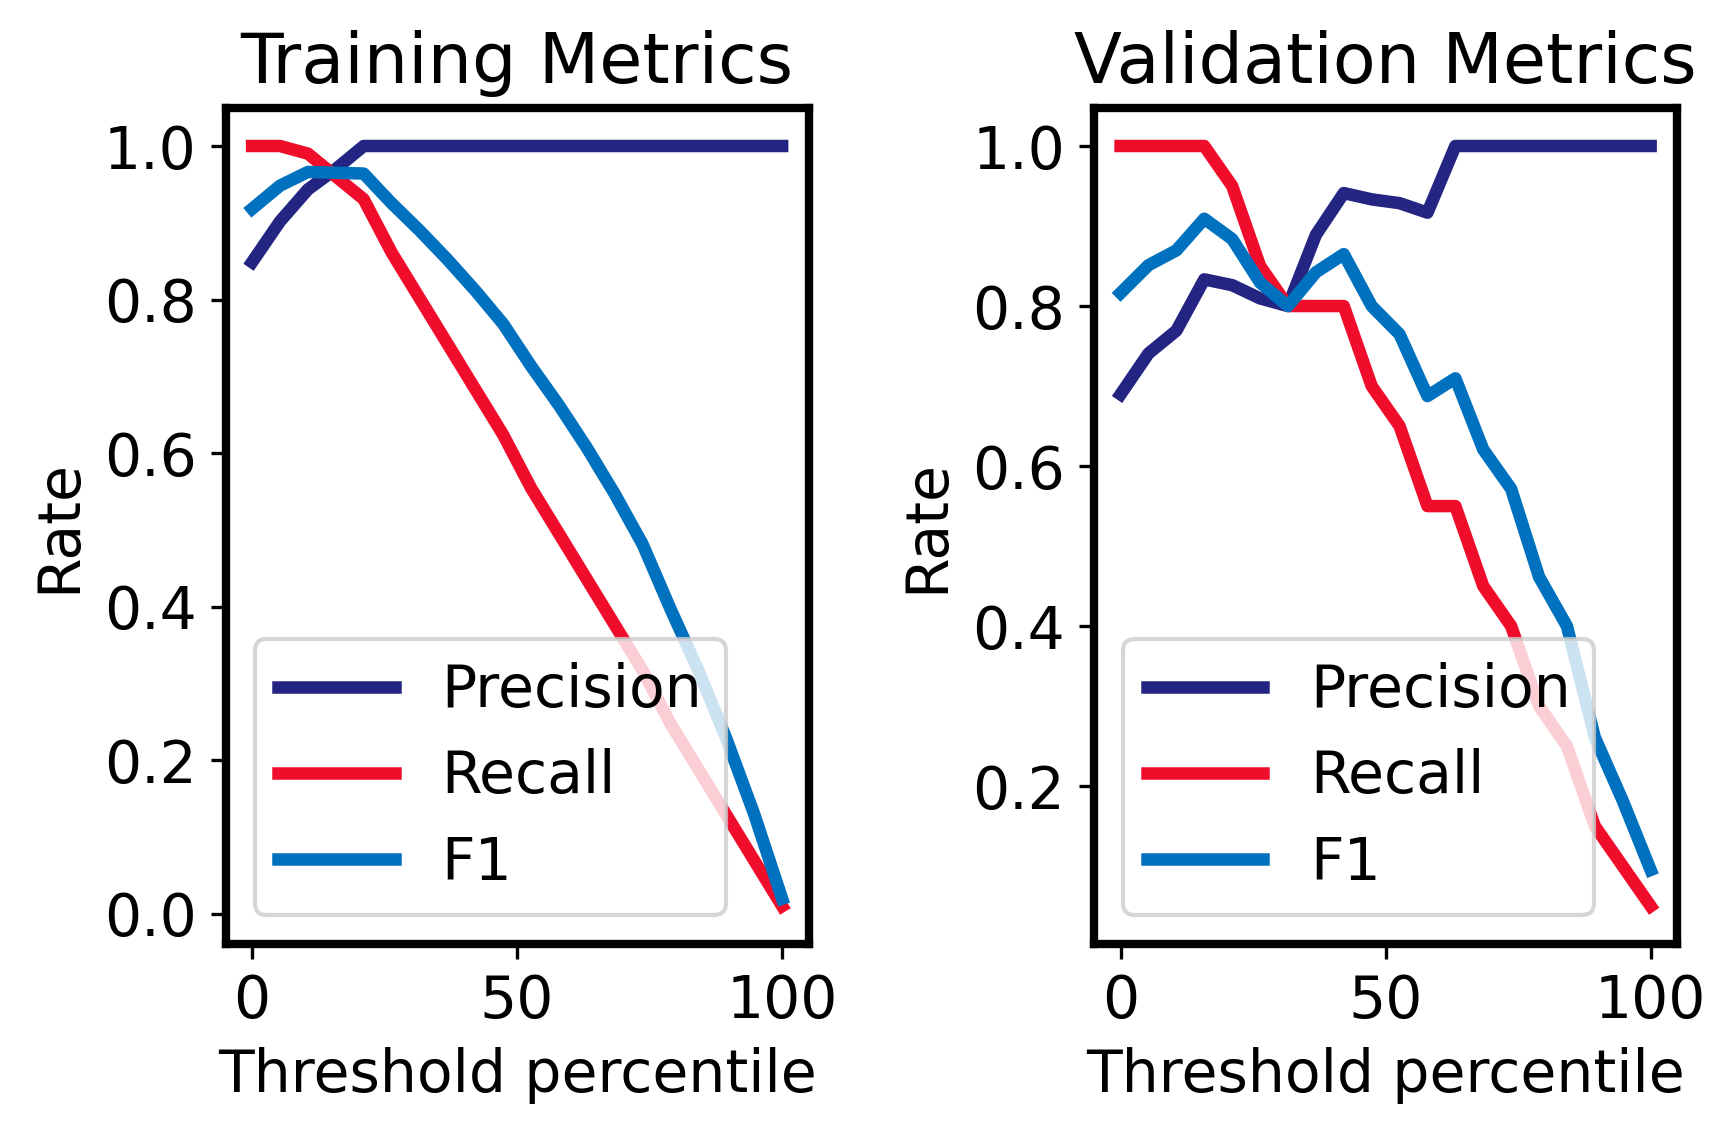

In [45]:
# Plot the training metrics (1st column of a 1x2 grid of plots)
plt.subplot(1, 2, 1)
plt.title('Training Metrics')
plt.plot(percentile, train_metrics)
plt.legend(['Precision', 'Recall', 'F1'])
plt.xlabel('Threshold percentile')
plt.ylabel('Rate')

# Plot the validation metrics (2nd column of a 1x2 grid of plots)
plt.subplot(1, 2, 2)
plt.title('Validation Metrics')
plt.plot(percentile, valid_metrics)
plt.legend(['Precision', 'Recall', 'F1'])
plt.xlabel('Threshold percentile')
plt.ylabel('Rate')

# Fixes spacing when using suplot
plt.tight_layout()

Using this, we can calculate the best threshold percentile -- using the percentile value that achieves the maximum F1 value for the validation data set. Again, we use the validation data set precisely to pick hyper-parameters like this.

In [46]:
i_max = np.argmax(valid_metrics[:, 2])
best_percentile = percentile[i_max]
print(best_percentile)

15.789473684210527


This shows us that the best threshold percentile for our make-shift classifier is around 16%.

Again, the use of the F1 score is simply the correct way to combine precision and recall, under the assumption that these two metrics are equally important to our problem. We can reflect a preference for one or the other -- again this preference depends on how the classifier will be used -- through the use of the $F_\beta$ score.

The equal weighting of precision and recall in formula for the $F_1$ score is reflected by the fact that the inverses of these values are averaged with equal proportions -- the 0.5 values in the denominator. We can alternatively weigh precision with a weight $\frac{1}{1+\beta}$ and recall with a weight of $\frac{\beta}{1 + \beta}$ -- selected so that these weights sum to 1. This yields the generalized $F_\beta$ score:

$$ F_\beta = \frac{1}{\frac{1}{1+\beta} \cdot \text{Precision}^{-1} + \frac{\beta}{1 + \beta} \cdot \text{Recall}^{-1}}.$$

The $\beta$ determines how much more influence recall should have when calculating a score, as compared to precision. If $\beta = 2$, then we wish to weigh recall with a weight twice as large as the one used to weigh precision. Colloquially, we treat recall as twice as important than precision; though this should be understood in the harmonic sense (i.e. as in the formula above). Similarly, if $\beta = 0.5$, we shall consider recall  half as important as precision.

In Python, we can use the `sklearn.metrics.fbeta_score`, passing in the value of $\beta$ in as an argument. First, we again redefine the metric calculation function to use the $F_\beta$ score.

In [47]:
from sklearn.metrics import fbeta_score

def calculate_metrics(percentile, theta, x_data, c_data, beta = 1):
    Phi = form_design_matrix(x_data)
    y = Phi @ theta
    
    y_thresh = np.percentile(y, percentile)
    c_model = [1 if y_i >= y_thresh else 0 for y_i in y]
    
    precision = precision_score(c_data, c_model)
    recall = recall_score(c_data, c_model)
    fbeta = fbeta_score(c_data, c_model, beta = beta)
    
    return precision, recall, fbeta

Next we recalculate the metric values versus percentile value, using a beta value of 0.5 as an example.

In [48]:
percentile = np.linspace(0, 100, 20)

# Train the base-model on training data
model = LogisticRegression(fit_intercept = False, C = 1e9)
Phi_train = form_design_matrix(x_train)
model.fit(Phi_train, c_train)
theta = model.coef_[0]

# Pre-allocate the matrices that will hold the precision, recall, and
# F-beta values for each percentile in the percentile array
train_metrics = np.zeros([len(percentile), 3])
valid_metrics = np.zeros([len(percentile), 3])

for i, p in enumerate(percentile):
    train_metrics[i,:] = calculate_metrics(p, theta, x_train, c_train, beta = 0.5)
    valid_metrics[i,:] = calculate_metrics(p, theta, x_valid, c_valid, beta = 0.5)

Then we plot these new metrics

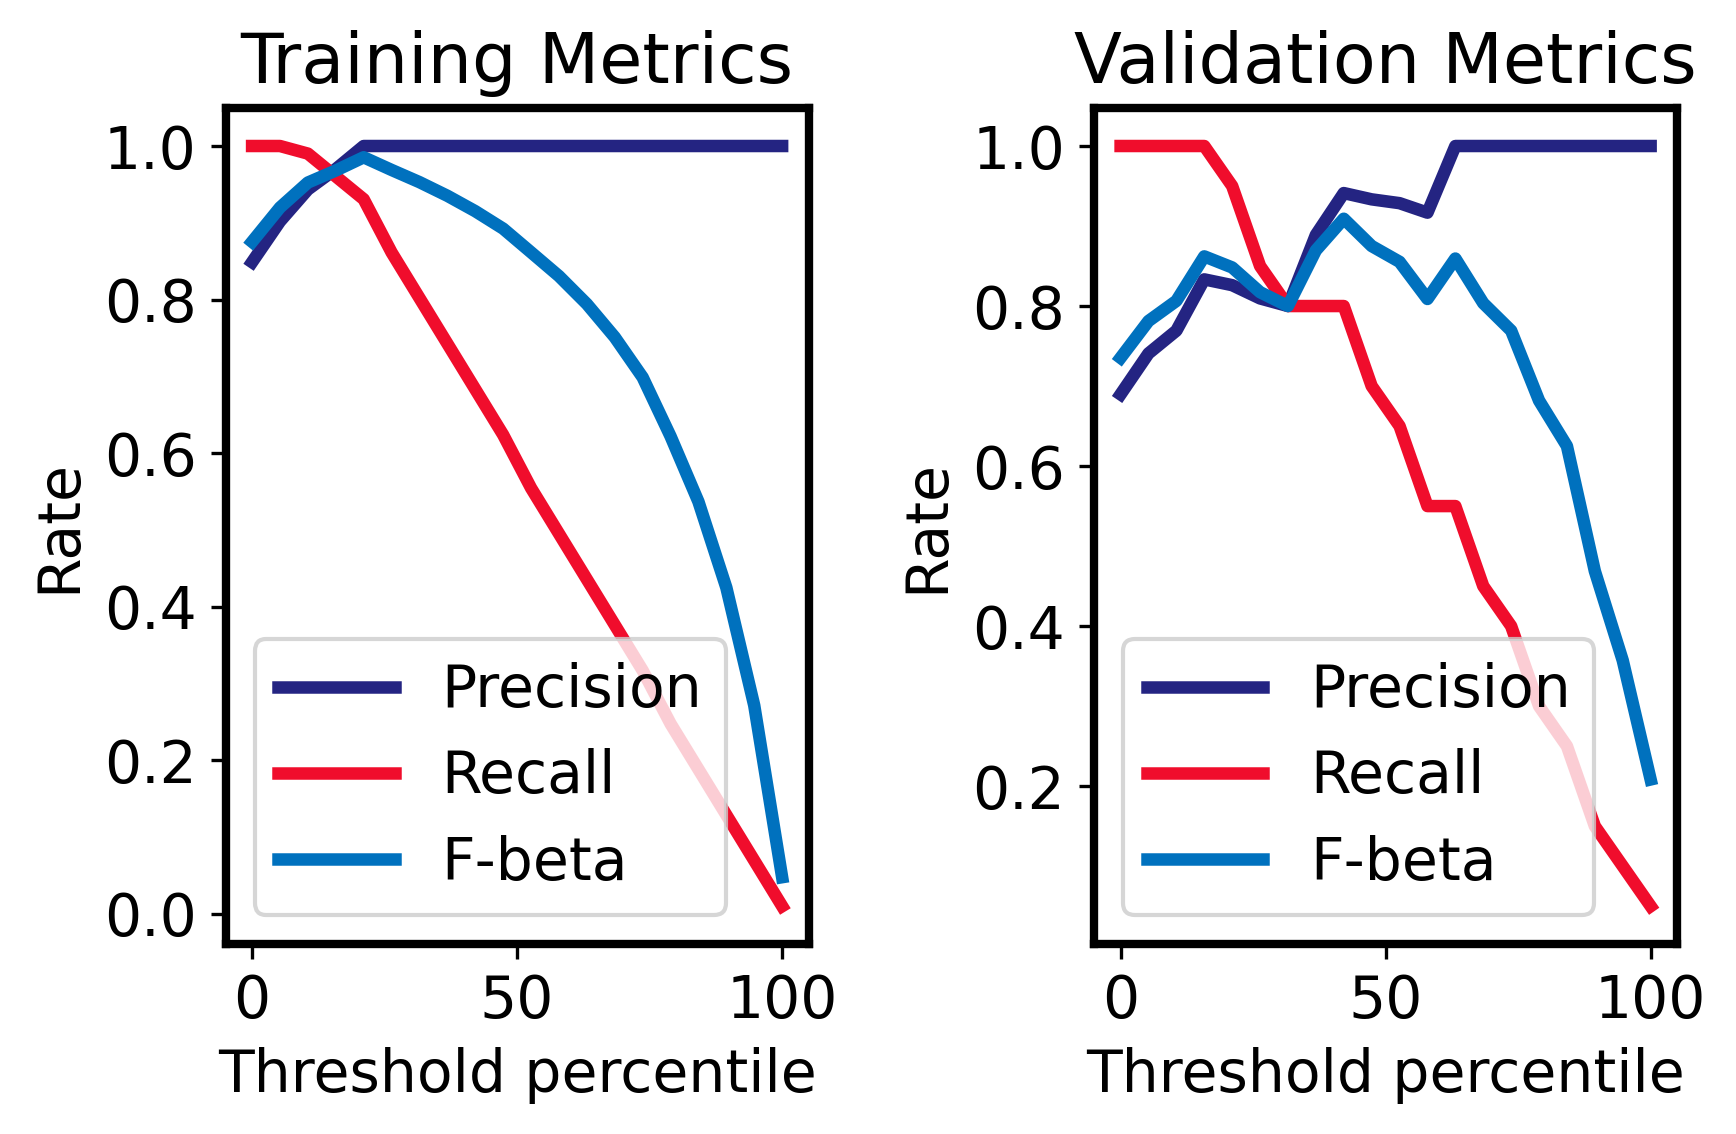

In [49]:
# Plot the training metrics (1st column of a 1x2 grid of plots)
plt.subplot(1, 2, 1)
plt.title('Training Metrics')
plt.plot(percentile, train_metrics)
plt.legend(['Precision', 'Recall', 'F-beta'])
plt.xlabel('Threshold percentile')
plt.ylabel('Rate')

# Plot the validation metrics (2nd column of a 1x2 grid of plots)
plt.subplot(1, 2, 2)
plt.title('Validation Metrics')
plt.plot(percentile, valid_metrics)
plt.legend(['Precision', 'Recall', 'F-beta'])
plt.xlabel('Threshold percentile')
plt.ylabel('Rate')

# Fixes spacing when using suplot
plt.tight_layout()

In [50]:
i_max = np.argmax(valid_metrics[:, 2])
best_percentile = percentile[i_max]
print(best_percentile)

42.10526315789474


With this increased emphasis on precision, we see that the optimal threshold percentile, based on the $F_{\beta = 0.5}$ score increased from 16 to about 42%. 

Again, the precise value of $\beta$ to use should reflect priorities of the problem at hand.

---

#### Exercise

We now turn our attention to back to identifying the best value of regularization parameter $C$. Using $F_\beta$ metric, select the best regularization parameter from among a set of potential parameter values of different orders of magnitude. Plot classification predictions from the optimal model.

---

# SVM
---

SVM, like Logistic Regression, uses the linear model to define the boundary between two classes. Once the coefficients $\boldsymbol \theta$ are obtained/trained from data, both methods are identical: use the sign of the linear model to classify the input value into one of two classes:

$$c(\boldsymbol x) = \text{sgn}( \boldsymbol \varphi(\boldsymbol x) \cdot \boldsymbol \theta).$$

Therefore, the only difference between SVM and Logistic Regression is in training, and in particular the choice of loss function. While we motivated Logistic Regression using Maximum Likelihood estimation, the  equivalent loss function that results in MLE estimate is **logistic lost** function, which you may derive directly from the form of the likelihood function. This is analogous to how the sum-of-squares loss is equivalent to the MLE estimate for linear regression under the assumption of Gaussian noise.

For SVM, we use a different loss function, namely the **Hinge Loss**. Given the data point $(\boldsymbol x_i, c_i)$ and a choice of parameters $\boldsymbol \theta$, the hinge loss is given by

$$ \begin{align}
L_\text{Hinge}(\boldsymbol \theta; \boldsymbol x_i, c_i) 
&=  [1 - c_i \boldsymbol\varphi(\boldsymbol x_i) \cdot \boldsymbol \theta]^+ \\
&= \max\left[0, 1 - c_i \boldsymbol\varphi(\boldsymbol x_i) \cdot \boldsymbol \theta\right]
\end{align} $$

Here, we assume that the class data takes on values between 1 and -1. 

To illustrate what the hinge loss captures, we consider the case where $c_i = 1$, and denote $y_i = \boldsymbol\varphi(\boldsymbol x_i) \cdot \boldsymbol \theta$. Below we plot the hinge loss as a function of $y_i$.

Text(0, 0.5, 'loss')

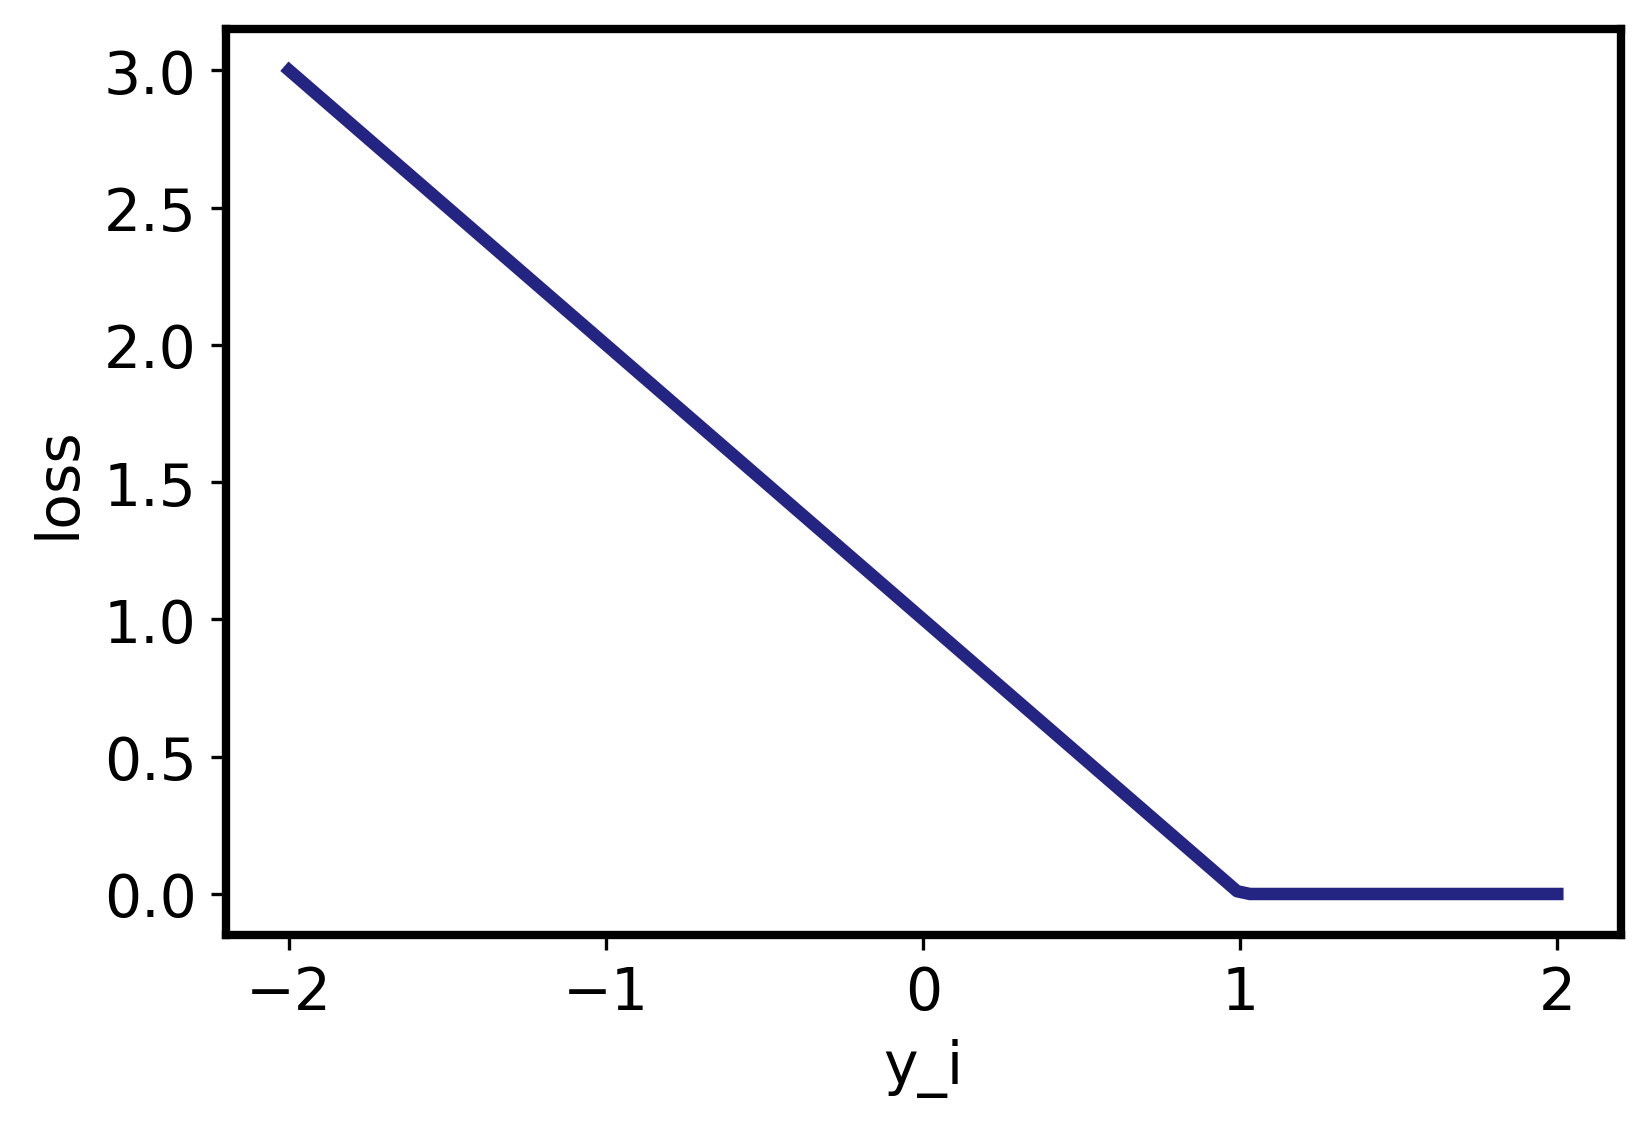

In [53]:
c_i = 1
y_i = np.linspace(-2, 2, 100)

loss = 1 - c_i*y_i

# By the definition of Hinge Loss, anything less than 0 is set to 0.
loss[loss < 0] = 0

# Plot the loss
plt.plot(y_i, loss)
plt.xlabel('y_i')
plt.ylabel('loss')

Thus the loss is 0 if $y_i > 1$ and increases as $y_i$ decreases away from 1. Because the loss is a penalty to be avoided (when selecting $\boldsymbol \theta$), let's delineate the scenarios we could encounter depending on what $y_i = \boldsymbol \varphi(\boldsymbol x_i) \cdot \boldsymbol \theta$ is:

* Case 1: $y_i \geq 1$. In this case, because $y_i > 0$ the classifier would correctly identify the the data point as belonging to the positive class, and we would incur zero loss for this correct classification.
* Case 2: $y_i < 0$. In this case,  the classifier would incorrectly identify the data point as belonging to the negative class, and we would incur a loss that grows the more negative $y_i$ is.
* Case 3: $0 \leq y_i < 1$. In this case, the classifier would correctly identify the data point as belonging to the positive class. However, we would still incur a moderate loss, which increases from 0 the further $y_i$ is from 1.

Case 3 in particular is interesting: even though the classifier is would predict the correct class, the prediction still incurs a penality for lying inside the margin between $0$ and 1. This margin is like a danger or buffer zone. Points in this zone result in predictions that are techincally correct but may be a bit too close to the boundary for comfort. Thus, by using the Hinge loss, we select $\boldsymbol \theta$ so that points are not just simply on the right side of the decision-boundary $\boldsymbol \varphi(\boldsymbol x) \cdot \boldsymbol \theta = 0$, but also sufficiently far away from this boundary (here, with zero loss once the points are a distance of 1 unit away from the boundary). In this way, SVM tries to maximize the margin from the boundary and the closest, support vectors.

To use SVM in Python, you can use the implementation in `sklearn.svm.SVC`. Like every other model in `sklearn`, we employ the 3 step procedure to train and make predictions from an SVC classifier:

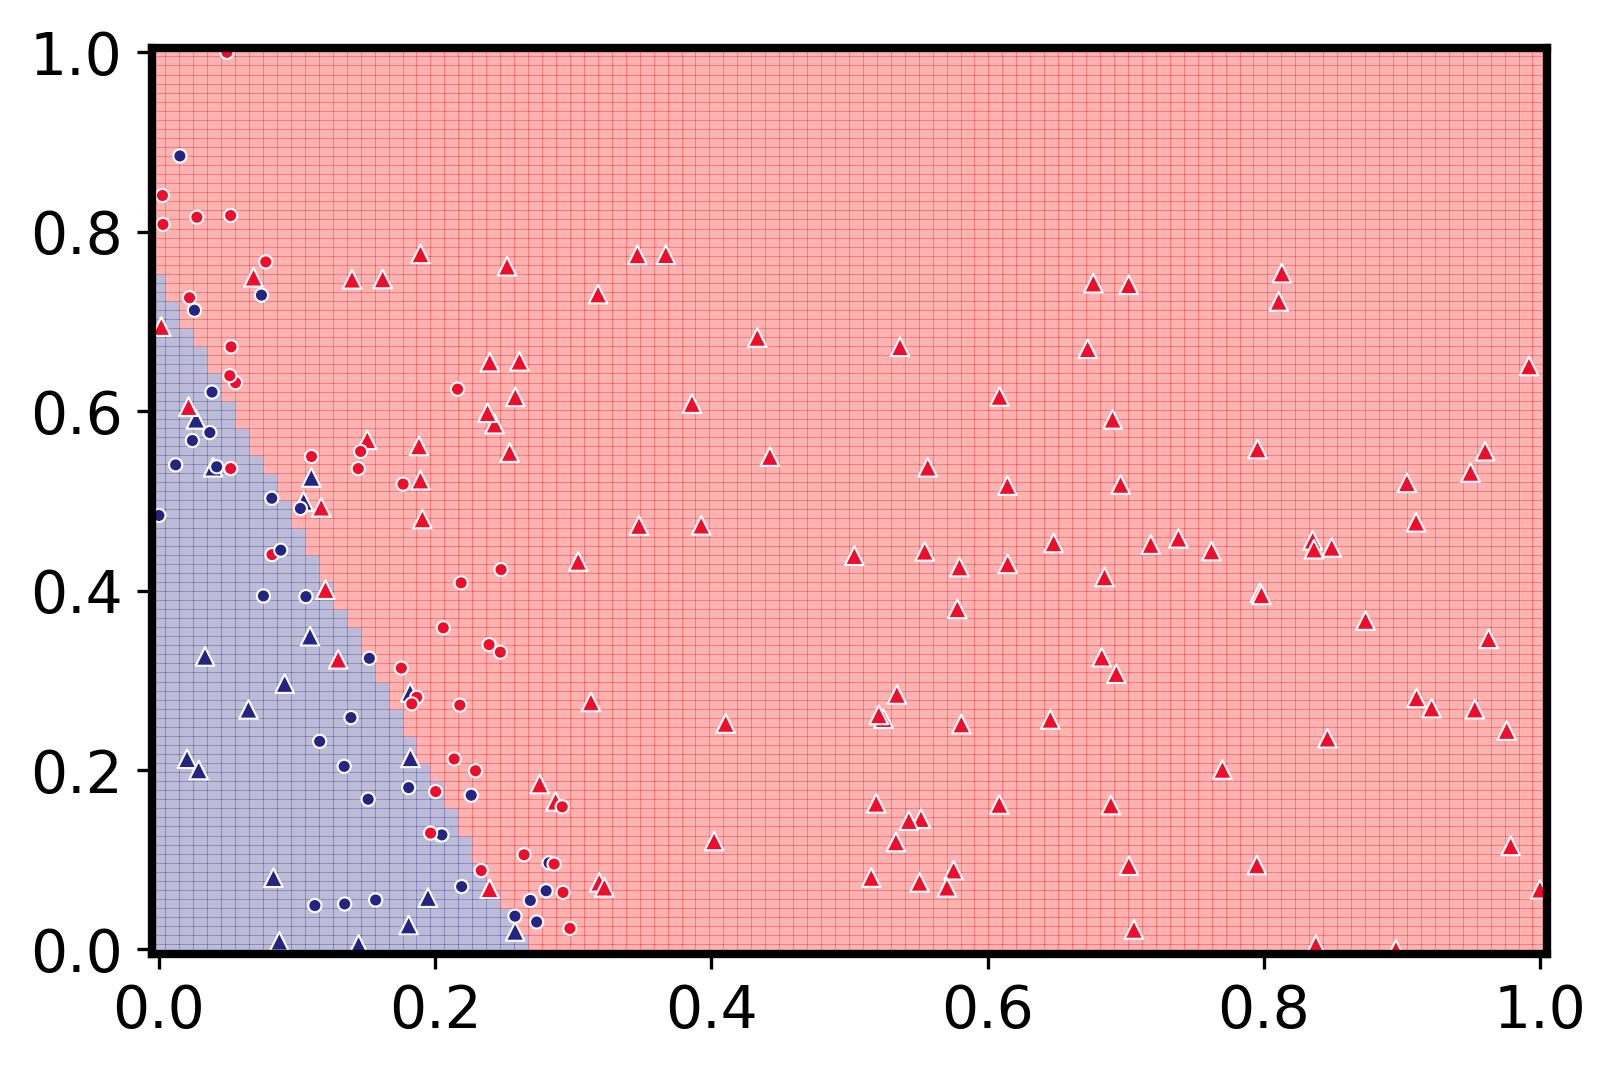

In [57]:
from sklearn.svm import SVC

model = SVC(C = 1e9, kernel='linear')
model.fit(Phi_train, c_train)
c_plot = model.predict(Phi_plot)
plot_classification(c_plot)

Checking the documentation of the `SVC` model, we note a few things:

1. The implementation of SVM in `sklearn` is actually kernelized-SVM. Thus we must specfy the kernel, for which we used the linear kernel. That is the kernel corresponds exactly to the dot-product of the untransformed features represented by columns of `Phi_train`. 
2. In fact, since we're specifying the kernel, we actually didn't have to explicitly build the design matrix and can pass in the raw data matrix where columns are the individual descriptors rather than pre-specified features (basis-functions on top of the descriptor values). 
3. Further, we can specify kernels other than the linear kernel. Please consult the documentation for the specification of a few built-in kernels -- these are identical to the kernels we have used before for other kernelized methods such as Ridge Regression.
4. Like Logistic regression, the implementation in `SVC` is also regularized, Thus we may pass in a regularization parameter, which can be optimized during validation.

---

#### Exercise

Repeat the classification of the above data using the SVM model, but try different kernels and regularization parameters. Use the validation data to select the optimal combination of kernel and regularization parameter, with the F1-score as your metric.

---

# Other classification models
---

The `sklearn` package contains implementations of several other classifiers. Refer to the documentation and usage guides on the `sklearn` website for a full list of available classification models, for example the examples listed here:

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py

In addition to the logistic regression and SVM, a few other models of interest (and ones we've discussed in class) include:

* $k$-nearest neighbors: in [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

* Classification trees: in [`sklearn.tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

* Bagging: in [`sklearn.ensemble.BaggingClassifer`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

* Random Forests: in [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

* Adaboost: in [`sklearn.ensemble.AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

Please consult the documentation and examples for details for their specific use, but in general these models are used like all the other `sklearn` models we've seen so far.

## $k$-nearest neighbors

## Classification Trees

# Ensemble Methods
---

##  Bagging

## Random Forests

## Boosting

# Class Imbalance
---

# Multiclass Classification
---